## Thermique sol

* isolant parfait (vide)

In [4]:
from netgen.geom2d import SplineGeometry
import matplotlib.pylab as plt

In [5]:
# Dimensions
domain_width, domain_height = 1, 2
house_width = .3
insulation_depth, insulation_thickness = .2, .02

# element size:
maxh_small = .02
maxh_large = .2

### Define the geometry

In [6]:
geo = SplineGeometry()

# Points
# note: `AppendPoint` assigns the point id (integer) to the variable

top_left = geo.AppendPoint (-domain_width, 0)
top_right = geo.AppendPoint (house_width, 0)
bottom_left = geo.AppendPoint (-domain_width, -domain_height)
bottom_right = geo.AppendPoint (house_width, -domain_height)

origin = geo.AppendPoint (.0, .0)
A = geo.AppendPoint (0, -insulation_depth)
B = geo.AppendPoint (insulation_thickness, -insulation_depth)
C = geo.AppendPoint (insulation_thickness, -0)

In [7]:
# Segments:

geo.Append(["line", top_right, C], leftdomain=1, rightdomain=0,
           maxh=maxh_small,
           bc='indoor')
geo.Append(["line", origin, top_left], leftdomain=1, rightdomain=0,
           bc='outdoor')
geo.Append(["line", bottom_left, top_left], leftdomain=0, rightdomain=1)
geo.Append(["line", bottom_right, top_right], leftdomain=1, rightdomain=0)
geo.Append(["line", bottom_left, bottom_right], leftdomain=1, rightdomain=0)

#geo.Append(["line", C, origin],    leftdomain=2, rightdomain=0, maxh=maxh_small)#, bc='hello2', maxh=.01)

geo.Append(["line", A, origin], leftdomain=1, rightdomain=0, bc='insulation')
geo.Append(["line", A, B], leftdomain=0, rightdomain=1, maxh=maxh_small, bc='insulation')
geo.Append(["line", B, C], leftdomain=0, rightdomain=1, maxh=maxh_small, bc='insulation')

#geo.SetMaterial(2, "insulation")
geo.SetMaterial(1, "soil")

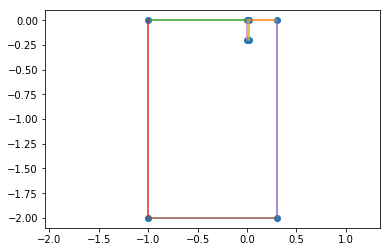

In [8]:
# Plot
plt.plot( geo.PointData()[0], geo.PointData()[1], 'o' )

xlim, ylim, x_points, y_points = geo.PlotData()
for xP, yP in zip(x_points, y_points):
    plt.plot( xP, yP, '-' )
    
plt.axis('equal');

### Mesh

In [9]:
# Mesh
mesh = geo.GenerateMesh(maxh=maxh_large)

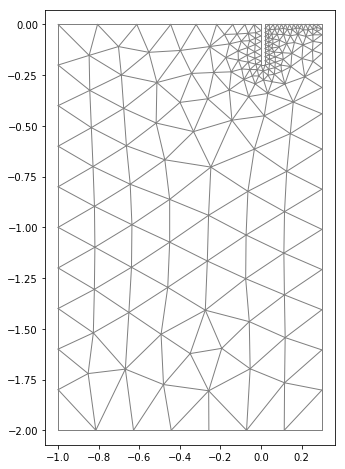

In [10]:
# Plot the mesh

# build list of unique edges
segments = set()
for el in mesh.Elements2D():
    a, b, c = sorted( [ p.nr for p in el.points ] )    
    segments.update([ (a, b), (b, c), (a, c) ]  )

# edges coords
mesh_points =  [(p[0], p[1]) for p in mesh.Points()]
x_coords, y_coords = [], []
for a, b in segments:
    xa, ya = mesh_points[a-1]
    xb, yb = mesh_points[b-1]
    x_coords.append([xa, xb])
    y_coords.append([ya, yb])
    
# Look for bounding box    
x_coords_flatten = [u for ab in x_coords for u in ab]
y_coords_flatten = [u for ab in y_coords for u in ab]
mesh_width = max(x_coords_flatten) - min(x_coords_flatten)
mesh_height = max(y_coords_flatten) - min(y_coords_flatten)

scale = 8/mesh_height

plt.figure(figsize=(scale*mesh_width, scale*mesh_height))
plt.plot(list( zip(*x_coords) ), list( zip(*y_coords) ), 'grey', linewidth=1)
plt.axis('equal');

### Define physics

https://ngsolve.org/docu/latest/how_to/howto_dirichlet.html

In [11]:
import ngsolve

In [12]:
mesh_ng = ngsolve.Mesh(mesh)

In [13]:
mesh_ng.GetBoundaries()

('indoor',
 'outdoor',
 'default',
 'default',
 'default',
 'insulation',
 'insulation',
 'insulation')

In [17]:
mesh_ng.GetMaterials()

('soil',)

In [15]:
help(mesh_ng)

Help on Mesh in module ngsolve.comp object:

class Mesh(pybind11_builtins.pybind11_object)
 |  NGSolve interface to the Netgen mesh. Provides access and functionality
 |  to use the mesh for finite element calculations.
 |  
 |  Parameters:
 |  
 |  mesh (netgen.Mesh): a mesh generated from Netgen
 |  
 |  Method resolution order:
 |      Mesh
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  BBBoundaries(...)
 |      BBBoundaries(self: ngsolve.comp.Mesh, pattern: str) -> ngsolve.comp.Region
 |      
 |      Return co dim 3 boundary mesh-region matching the given regex pattern
 |  
 |  BBoundaries(...)
 |      BBoundaries(self: ngsolve.comp.Mesh, pattern: str) -> ngsolve.comp.Region
 |      
 |      Return co dim 2 boundary mesh-region matching the given regex pattern
 |  
 |  Boundaries(...)
 |      Boundaries(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. Boundaries(self: ngsolve.comp.Mesh, pattern: str) -> ng

In [24]:
mip = mesh_ng(0, 0, 0)
print(mip)

In [26]:
mip.pnt

(1.0, -0.0, 0.0)

In [21]:
mip = mesh_ng([0, .1], [0, 0], [0, 0])

In [23]:
mip

array([( 1.        , -0.        ,  0.,   3.46342468e-316, 0, 25),
       ( 0.98778862,  0.01221138,  0.,   3.46342468e-316, 0, 18)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('meshptr', '<f8'), ('VorB', '<i4'), ('nr', '<i4')])

In [22]:
help( mip )

Help on ndarray object:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |      Any objec

In [27]:
# solve the Poisson equation -Delta u = f
# with Dirichlet boundary condition u = 0


# Convert mesh:
ng_mesh = ngsolve.Mesh(mesh)

# H1-conforming finite element space
fes = ngsolve.H1(ng_mesh, order=3, dirichlet='outdoor')

# define trial- and test-functions
u = fes.TrialFunction()
v = fes.TestFunction()

# the right hand side
f = ngsolve.LinearForm(fes)
f += ngsolve.SymbolicLFI(32)

# the bilinear-form 
a = ngsolve.BilinearForm(fes, symmetric=True)
a += ngsolve.SymbolicBFI(ngsolve.grad(u)*ngsolve.grad(v))

a.Assemble()
f.Assemble()

# the solution field 
gfu = ngsolve.GridFunction(fes)
gfu.vec.data = a.mat.Inverse(fes.FreeDofs(), inverse="sparsecholesky") * f.vec
# print (u.vec)



In [31]:
vv = gfu.vec

In [45]:
gfu.vec.FV().NumPy() # Flat Vector

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [28]:
help( gfu )

Help on GridFunction in module ngsolve.comp object:

class GridFunction(ngsolve.fem.CoefficientFunction, NGS_Object)
 |  a field approximated in some finite element space
 |   Keyword arguments can be:
 |  multidim: 
 |   Multidimensional GridFunction
 |  nested: bool = False
 |   Generates prolongation matrices for each mesh level and prolongates
 |   the solution onto the finer grid after a refinement.
 |  
 |  Method resolution order:
 |      GridFunction
 |      ngsolve.fem.CoefficientFunction
 |      NGS_Object
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  CF(...)
 |      CF(self: ngsolve.comp.GridFunction, diffop: ngsolve.fem.DifferentialOperator) -> ngsolve.fem.CoefficientFunction
 |      
 |      
 |      
 |      Parameters:
 |      
 |      diffop : ngsolve.fem.DifferentialOperator
 |        input differential operator
 |  
 |  Deriv(...)
 |      Deriv(self: ngsolve.comp.GridFunction) -> ngsolve.fem.CoefficientFuncti

In [57]:
type(ngsolve.fem.NODE_TYPE.VERTEX)

ngsolve.fem.NODE_TYPE

In [52]:
for vert in ng_mesh.vertices:
    print(vert)
    break

V0


In [60]:
mesh_point = [vert.point for vert in ng_mesh.vertices]

In [63]:
gfu( ng_mesh( mesh_point ) )

ValueError: array has incorrect number of dimensions: 2; expected 1

In [76]:
mip = ng_mesh([[0.2, -0.4], [.1, -.5]])

In [78]:
mip

array([[( 0.01543697,  0.98456303,  0.,   2.46948713e-316, 0,  6),
        ( 0.35970964,  0.64029036,  0.,   2.46948713e-316, 0, 31)],
       [( 0.98778862,  0.01221138,  0.,   2.46948713e-316, 0, 18),
        ( 0.67087057,  0.32912943,  0.,   2.46948713e-316, 0, 32)]],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('meshptr', '<f8'), ('VorB', '<i4'), ('nr', '<i4')])

In [90]:
gfu.Save('test.txt')

In [13]:
import numpy as np

In [ ]:
gfu(np.array((0, 0, 0)))

In [3]:
help( ngsolve.mpi )

AttributeError: module 'ngsolve' has no attribute 'mpi'

In [89]:
help( gfu )

Help on GridFunction in module ngsolve.comp object:

class GridFunction(ngsolve.fem.CoefficientFunction, NGS_Object)
 |  a field approximated in some finite element space
 |   Keyword arguments can be:
 |  nested: bool = False
 |   Generates prolongation matrices for each mesh level and prolongates
 |   the solution onto the finer grid after a refinement.
 |  multidim: 
 |   Multidimensional GridFunction
 |  
 |  Method resolution order:
 |      GridFunction
 |      ngsolve.fem.CoefficientFunction
 |      NGS_Object
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  CF(...)
 |      CF(self: ngsolve.comp.GridFunction, diffop: ngsolve.fem.DifferentialOperator) -> ngsolve.fem.CoefficientFunction
 |      
 |      
 |      
 |      Parameters:
 |      
 |      diffop : ngsolve.fem.DifferentialOperator
 |        input differential operator
 |  
 |  Deriv(...)
 |      Deriv(self: ngsolve.comp.GridFunction) -> ngsolve.fem.CoefficientFuncti

In [82]:
tt = gfu.vec

In [88]:
tt.FV()

       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
       0
 

In [58]:
ng_mesh.Elements(ngsolve.fem.NODE_TYPE.VERTEX)

TypeError: Elements(): incompatible function arguments. The following argument types are supported:
    1. (self: ngsolve.comp.Mesh, VOL_or_BND: ngsolve.comp.VorB = VorB.VOL) -> ngcomp::ElementRange

Invoked with: <ngsolve.comp.Mesh object at 0x7f7259238150>, NODE_TYPE.VERTEX